The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install flax
!pip install d2l==1.0.0-beta0


# Transformers for Vision
:label:`sec_vision-transformer`

The Transformer architecture was initially proposed
for sequence-to-sequence learning,
with a focus on machine translation.
Subsequently, Transformers emerged as the model of choice
in various natural language processing tasks :cite:`Radford.Narasimhan.Salimans.ea.2018,Radford.Wu.Child.ea.2019,brown2020language,Devlin.Chang.Lee.ea.2018,raffel2020exploring`.
However, in the field of computer vision
the dominant architecture has remained
the CNN (:numref:`chap_modern_cnn`).
Naturally, researchers started to wonder
if it might be possible to do better
by adapting Transformer models to image data.
This question sparked immense interest
in the computer vision community.
Recently, :citet:`ramachandran2019stand` proposed
a scheme for replacing convolution with self-attention.
However, its use of specialized patterns in attention
makes it hard to scale up models on hardware accelerators.
Then, :citet:`cordonnier2020relationship` theoretically proved
that self-attention can learn to behave similarly to convolution.
Empirically, $2 \times 2$ patches were taken from images as inputs,
but the small patch size makes the model
only applicable to image data with low resolutions.

Without specific constraints on patch size,
*vision Transformers* (ViTs)
extract patches from images
and feed them into a Transformer encoder
to obtain a global representation,
which will finally be transformed for classification :cite:`Dosovitskiy.Beyer.Kolesnikov.ea.2021`.
Notably, Transformers show better scalability than CNNs:
and when training larger models on larger datasets,
vision Transformers outperform ResNets by a significant margin.
Similar to the landscape of network architecture design in natural language processing,
Transformers have also become a game-changer in computer vision.


In [1]:
import jax
from flax import linen as nn
from jax import numpy as jnp
from d2l import jax as d2l

## Model

:numref:`fig_vit` depicts
the model architecture of vision Transformers.
This architecture consists of a stem
that patchifies images,
a body based on the multilayer Transformer encoder,
and a head that transforms the global representation
into the output label.

![The vision Transformer architecture. In this example, an image is split into nine patches. A special “&lt;cls&gt;” token and the nine flattened image patches are transformed via patch embedding and $n$ Transformer encoder blocks into ten representations, respectively. The “&lt;cls&gt;” representation is further transformed into the output label.](http://d2l.ai/_images/vit.svg)
:label:`fig_vit`

Consider an input image with height $h$, width $w$,
and $c$ channels.
Specifying the patch height and width both as $p$,
the image is split into a sequence of $m = hw/p^2$ patches,
where each patch is flattened to a vector of length $cp^2$.
In this way, image patches can be treated similarly to tokens in text sequences by Transformer encoders.
A special “&lt;cls&gt;” (class) token and
the $m$ flattened image patches are linearly projected
into a sequence of $m+1$ vectors,
summed with learnable positional embeddings.
The multilayer Transformer encoder
transforms $m+1$ input vectors
into the same number of output vector representations of the same length.
It works exactly the same way as the original Transformer encoder in :numref:`fig_transformer`,
only differing in the position of normalization.
Since the “&lt;cls&gt;” token attends to all the image patches
via self-attention (see :numref:`fig_cnn-rnn-self-attention`),
its representation from the Transformer encoder output
will be further transformed into the output label.

## Patch Embedding

To implement a vision Transformer, let's start
with patch embedding in :numref:`fig_vit`.
Splitting an image into patches
and linearly projecting these flattened patches
can be simplified as a single convolution operation,
where both the kernel size and the stride size are set to the patch size.


In [2]:
class PatchEmbedding(nn.Module):
    img_size: int = 96
    patch_size: int = 16
    num_hiddens: int = 512

    def setup(self):
        def _make_tuple(x):
            if not isinstance(x, (list, tuple)):
                return (x, x)
            return x
        img_size, patch_size = _make_tuple(self.img_size), _make_tuple(self.patch_size)
        self.num_patches = (img_size[0] // patch_size[0]) * (
            img_size[1] // patch_size[1])
        self.conv = nn.Conv(self.num_hiddens, kernel_size=patch_size,
                            strides=patch_size, padding='SAME')

    def __call__(self, X):
        # Output shape: (batch size, no. of patches, no. of channels)
        X = self.conv(X)
        return X.reshape((X.shape[0], -1, X.shape[3]))

In the following example, taking images with height and width of `img_size` as inputs,
the patch embedding outputs `(img_size//patch_size)**2` patches
that are linearly projected to vectors of length `num_hiddens`.


In [3]:
img_size, patch_size, num_hiddens, batch_size = 96, 16, 512, 4
patch_emb = PatchEmbedding(img_size, patch_size, num_hiddens)
X = jnp.zeros((batch_size, img_size, img_size, 3))
output, _ = patch_emb.init_with_output(d2l.get_key(), X)
d2l.check_shape(output, (batch_size, (img_size//patch_size)**2, num_hiddens))

## Vision Transformer Encoder
:label:`subsec_vit-encoder`

The MLP of the vision Transformer encoder is slightly different
from the positionwise FFN of the original Transformer encoder
(see :numref:`subsec_positionwise-ffn`).
First, here the activation function uses the Gaussian error linear unit (GELU),
which can be considered as a smoother version of the ReLU :cite:`Hendrycks.Gimpel.2016`.
Second, dropout is applied to the output of each fully connected layer in the MLP for regularization.


In [4]:
class ViTMLP(nn.Module):
    mlp_num_hiddens: int
    mlp_num_outputs: int
    dropout: float = 0.5

    @nn.compact
    def __call__(self, x, training=False):
        x = nn.Dense(self.mlp_num_hiddens)(x)
        x = nn.gelu(x)
        x = nn.Dropout(self.dropout, deterministic=not training)(x)
        x = nn.Dense(self.mlp_num_outputs)(x)
        x = nn.Dropout(self.dropout, deterministic=not training)(x)
        return x

The vision Transformer encoder block implementation
just follows the pre-normalization design in :numref:`fig_vit`,
where normalization is applied right *before* multi-head attention or the MLP.
In contrast to post-normalization ("add & norm" in :numref:`fig_transformer`),
where normalization is placed right *after* residual connections,
pre-normalization leads to more effective or efficient training for Transformers :cite:`baevski2018adaptive,wang2019learning,xiong2020layer`.


In [5]:
class ViTBlock(nn.Module):
    num_hiddens: int
    mlp_num_hiddens: int
    num_heads: int
    dropout: float
    use_bias: bool = False

    def setup(self):
        self.attention = d2l.MultiHeadAttention(self.num_hiddens, self.num_heads,
                                                self.dropout, self.use_bias)
        self.mlp = ViTMLP(self.mlp_num_hiddens, self.num_hiddens, self.dropout)

    @nn.compact
    def __call__(self, X, valid_lens=None, training=False):
        X = X + self.attention(*([nn.LayerNorm()(X)] * 3),
                               valid_lens, training=training)[0]
        return X + self.mlp(nn.LayerNorm()(X), training=training)

Just as in :numref:`subsec_transformer-encoder`,
no vision Transformer encoder block changes its input shape.


In [6]:
X = jnp.ones((2, 100, 24))
encoder_blk = ViTBlock(24, 48, 8, 0.5)
d2l.check_shape(encoder_blk.init_with_output(d2l.get_key(), X)[0], X.shape)

## Putting It All Together

The forward pass of vision Transformers below is straightforward.
First, input images are fed into an `PatchEmbedding` instance,
whose output is concatenated with the “&lt;cls&gt;”  token embedding.
They are summed with learnable positional embeddings before dropout.
Then the output is fed into the Transformer encoder that stacks `num_blks` instances of the `ViTBlock` class.
Finally, the representation of the “&lt;cls&gt;”  token is projected by the network head.


In [7]:
class ViT(d2l.Classifier):
    """Vision Transformer."""
    img_size: int
    patch_size: int
    num_hiddens: int
    mlp_num_hiddens: int
    num_heads: int
    num_blks: int
    emb_dropout: float
    blk_dropout: float
    lr: float = 0.1
    use_bias: bool = False
    num_classes: int = 10
    training: bool = False

    def setup(self):
        self.patch_embedding = PatchEmbedding(self.img_size, self.patch_size,
                                              self.num_hiddens)
        self.cls_token = self.param('cls_token', nn.initializers.zeros,
                                    (1, 1, self.num_hiddens))
        num_steps = self.patch_embedding.num_patches + 1  # Add the cls token
        # Positional embeddings are learnable
        self.pos_embedding = self.param('pos_embed', nn.initializers.normal(),
                                        (1, num_steps, self.num_hiddens))
        self.blks = [ViTBlock(self.num_hiddens, self.mlp_num_hiddens,
                              self.num_heads, self.blk_dropout, self.use_bias)
                    for _ in range(self.num_blks)]
        self.head = nn.Sequential([nn.LayerNorm(), nn.Dense(self.num_classes)])

    @nn.compact
    def __call__(self, X):
        X = self.patch_embedding(X)
        X = jnp.concatenate((jnp.tile(self.cls_token, (X.shape[0], 1, 1)), X), 1)
        X = nn.Dropout(emb_dropout, deterministic=not self.training)(X + self.pos_embedding)
        for blk in self.blks:
            X = blk(X, training=self.training)
        return self.head(X[:, 0])

## Training

Training a vision Transformer on the Fashion-MNIST dataset is just like how CNNs were trained in :numref:`chap_modern_cnn`.


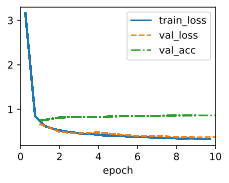

In [8]:
img_size, patch_size = 96, 16
num_hiddens, mlp_num_hiddens, num_heads, num_blks = 512, 2048, 8, 2
emb_dropout, blk_dropout, lr = 0.1, 0.1, 0.1
model = ViT(img_size, patch_size, num_hiddens, mlp_num_hiddens, num_heads,
            num_blks, emb_dropout, blk_dropout, lr)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(img_size, img_size))
trainer.fit(model, data)

## Summary and Discussion

You may have noticed that for small datasets like Fashion-MNIST,
our implemented vision Transformer
does not outperform the ResNet in :numref:`sec_resnet`.
Similar observations can be made even on the ImageNet dataset (1.2 million images).
This is because Transformers *lack* those useful principles in convolution,
such as translation invariance and locality (:numref:`sec_why-conv`).
However, the picture changes when training larger models on larger datasets (e.g., 300 million images),
where vision Transformers outperform ResNets by a large margin in image classification, demonstrating
intrinsic superiority of Transformers in scalability :cite:`Dosovitskiy.Beyer.Kolesnikov.ea.2021`.
The introduction of vision Transformers
has changed the landscape of network design for modeling image data.
They were soon shown to be effective on the ImageNet dataset
with data-efficient training strategies of DeiT :cite:`touvron2021training`.
However, the quadratic complexity of self-attention
(:numref:`sec_self-attention-and-positional-encoding`)
makes the Transformer architecture
less suitable for higher-resolution images.
Towards a general-purpose backbone network in computer vision,
Swin Transformers addressed the quadratic computational complexity
with respect to image size (:numref:`subsec_cnn-rnn-self-attention`)
and reinstated convolution-like priors,
extending the applicability of Transformers to a range of computer vision tasks
beyond image classification with state-of-the-art results :cite:`liu2021swin`.

## Exercises

1. How does the value of `img_size` affect training time?
1. Instead of projecting the “&lt;cls&gt;” token representation to the output, how would you project the averaged patch representations? Implement this change and see how it affects the accuracy.
1. Can you modify hyperparameters to improve the accuracy of the vision Transformer?


[Discussions](https://discuss.d2l.ai/t/18032)
